# Dynamical Sampling on Graphs

In the interactive code below you can 

* Build a graph by specifying its nodes and edges: it visulaizes the graph and returns the Laplacian spectrum.

* Set the sampling locations, the number of iterations and the PW dimension, it returns the uper and lower frame bounds of the resulting iterative system. 

In [256]:
###### nbi:hide_in

from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))


In [257]:
###### nbi:hide_in

# Importing needed libraries 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh, svds
from scipy.linalg import eigh

# Creating the graph class
class Graph(object):
    r"""
    Args:
        edges ([num_edges, 3] array): Graph connectivity in COO format 
        (instead of saving the adjacency matrix coo format saves only the node 
        values so the weights need to be given separetely). Third argument is 
        the weight. 
    """
    def __init__(self,  N_nodes, edges, edge_attr=None, samples=[], **kwargs):
        self.edges = edges
        self.N_nodes = N_nodes
        self.nodes = [i for i in range(N_nodes)]
        self.samples = samples
        
    def adj(self):
        adjacency_matr = np.zeros([self.N_nodes, self.N_nodes])
        for idx, row in enumerate(self.edges):
            adjacency_matr[row[0], row[1]] = row[2]
            adjacency_matr[row[1], row[0]] = adjacency_matr[row[0], row[1]]
        return adjacency_matr
        
    def add_node(self):
        self.N_nodes += 1
        self.nodes.append(max(self.nodes)+1)
            
    def add_edge(self, edge):
        if edge!=None:
            self.edges.append(edge)
            
    def add_sample(self, node):
        if node not in samples:
            self.samples.append(node)
            
    def del_node(self, node):
        if node in self.nodes:
            self.edges[:] = [item for item in self.edges if item[0]!=node and item[1]!=node]
            self.nodes.remove(node)
            self.samples.remove(node)
    
    def del_edge(self, pair):
        self.edges[:] = [item for item in self.edges if item[:2]!=pair and item[:2]!=(pair[1], pair[0])]
        
    def del_sample(self, node):
        self.samples.remove(node)
                       
    #reset graph
    def reset(self):
        self.N_nodes = 2
        self.nodes = [i for i in range(N_nodes)]
        self.edges = [(0, 1, 1)]
    
    def lapl_eigen(self):
        Adj = self.adj()
        Lapl = csgraph.laplacian(Adj, normed=False)
        vals = eigh(Lapl, eigvals_only=True)
        return vals

## 1. Setting up the graph

In [259]:
###### nbi:hide_in

from IPython.display import display, clear_output

# The basic graph
N_nodes=2
edges = [(0, 1, 1)]
samples = []

# Generate the graph
G = Graph(N_nodes, edges, samples=samples)

def draw_graph(G, ax): 
    #create the graph
    Gnx = nx.Graph()
    Gnx.add_nodes_from(G.nodes)
    Gnx.add_weighted_edges_from(G.edges)
    
    # colors
    node_colors = ["red" if nodes in G.samples else "blue" for nodes in G.nodes]
    
    #plot
    ax.cla()
    nx.draw_networkx(Gnx, ax=ax, node_color=node_colors)
    clear_output(wait = True)

# edge display
def edge_disp(G):
    grid = GridspecLayout(G.N_nodes+1, G.N_nodes+2, justify_items='center')
    for i in range(1, G.N_nodes+1):
        if G.N_nodes>2:
            grid[0,i+1] = widgets.Label(str(G.nodes[i-1]))
            grid[i,1] = widgets.Label(str(G.nodes[i-1]))
        for j in range(i+1, G.N_nodes+2):
            grid[i,j] = widgets.FloatText(
                value=0,
                min=0,
                max=10.0,
                step=0.1,
                disabled=False,
                display='inline-flex',
                layout={'width': '40px'},
                color="b",
                description_tooltip=str(i-1)+" "+str(j-2)
            )
            grid[j-1,i+1] = widgets.FloatText(
                value=0,
                min=0,
                max=10.0,
                step=0.1,
                disabled=False,
                display='inline-flex',
                layout={'width': '40px'},
                color="b",
                description_tooltip=str(i-1)+" "+str(j-2)
            )
            l = widgets.link((grid[j-1,i+1], 'value'), (grid[i,j], 'value'))
            
        grid[i,0] = widgets.Checkbox(
            value=False,
            description_tooltip=str(i-1))
    grid[0, 0] =  widgets.Label("Samples")
    for edge in G.edges:
        i,j = sorted([edge[0], edge[1]])
        grid[i+1,j+2].value = edge[2]
    for node in G.samples:
        i = G.nodes.index(node)
        grid[i+1, 0].value = True
    return grid  

def draw_widget(G):
    grid = edge_disp(G)
    draw_graph(G, ax)
    display(grid)
    eig = G.lapl_eigen()
    print("Laplacian eigenvalues are \n {}".format(eig))
    for i in range(1, G.N_nodes+1):
        for j in range(i+1, G.N_nodes+2):
            grid[i,j].observe(on_value_change, names='value')
        grid[i,0].observe(on_click_change, names='value')

Output()

<IPython.core.display.Javascript object>


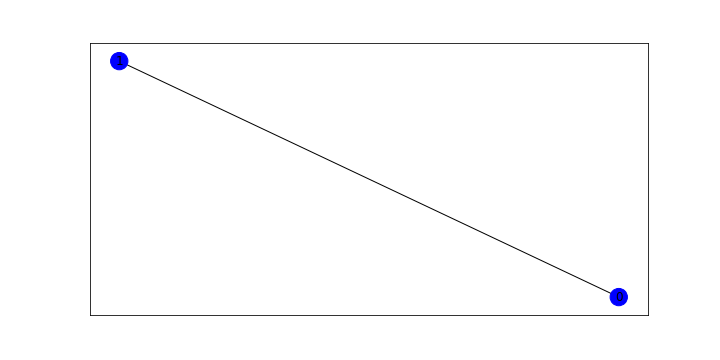

In [260]:
###### nbi:hide_in
%matplotlib notebook

import ipywidgets as widgets
from ipywidgets import Button, Layout, GridspecLayout


fig, ax = plt.subplots(figsize=(10, 5))
draw_graph(G, ax)
output = widgets.Output()

def on_value_change(change):
    with output:
        if change["old"]==0 and change["new"]>0:
            edge_index =[int(num) for num in change.owner.description_tooltip.split()]
            edge = (edge_index[0], edge_index[1], change["new"])
            G.add_edge(edge)
            draw_widget(G)
        if change["new"]<0:
            raise NameError('Weights must be non-negative')
                
def on_click_change(change):
    with output:
        if change["new"]==True:
            node =int(change.owner.description_tooltip)
            G.add_sample(node)
        if change["new"]==False:
            node =int(change.owner.description_tooltip)
            G.del_sample(node)
        draw_widget(G)
        
# add_node button
button1 = widgets.Button(
    description='Add node',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def button1_click(b):
    with output:
        G.add_node()
        draw_widget(G)
        
# reset graph
button2 = widgets.Button(
    description='Reset graph',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def button2_click(b):
    with output:
        G.reset()
        draw_widget(G)

# reset samples
button3 = widgets.Button(
    description='Reset samples',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def button3_click(b):
    with output:
        draw_graph(G, ax)

button1.on_click(button1_click)
button2.on_click(button2_click)

display(widgets.HBox([button2, button1]), output, fig);